# Gun-Related Deaths in the US and Outside of the US
### Amber Kiser, University of Utah

## Abstract
Every year thousands of people die in gun-related incidents in the United States. Within the US, individual states have differing levels of gun legislation in place. The Law Center to Prevent Gun Violence in conjunction with the Brady Center evaluates the strength of these gun laws and ranks the states accordingly. A study in 2013 and again in 2017 determined states with more stringent gun legislation have lower rates of gun-related homicides and suicides. Data about gun-related deaths was retrieved from the Centers for Disease Control and Prevention. Fatality rates were calculated based on state by state population data from the US Census. Statistical tests were performed to confirmed states with the highest levels of gun laws subsequently had lower fatality rates. Outside of the US, many countries enforce very stringent gun control laws. In Australia, citizens are not allowed to own handguns. Gun-related deaths in the US were compared to two of these countries with stricter gun laws, the United Kingdom and Australia. The US had a statistically greater rate of gun-related fatalities compared to the UK and Australia. In the US, more research is needed and action to prevent gun-related deaths. This will most likely take a great change in public opinion.

## Introduction
Research related to gun violence has been seriously underfunded in the past few decades. This stems from the Dickey Amendment enacted in 1996, which prevents funding to go toward gun-related research at the CDC.<sup>1</sup> Despite this, in recent years there has been more interest in understanding the efficacy of gun legislation. A 2013 study found states with more stringent gun laws had statistically lower gun-related fatality rates.<sup>2</sup> A further review from 2017 was able to highlight stronger laws requiring background checks and permit-to-purchases were associated with decreased firearm homicide rates.<sup>3</sup> This analysis sought to test this hypothesis that stronger gun laws are associated with lower gun-related fatality rates. To further investigate this, a second hypothesis was tested to see if other countries with even more stringent gun laws, namely the United Kingdom and Australia, saw statistically fewer gun-related deaths. 

In [1]:
library(dplyr)
library(lubridate)
library(ggplot2)
#install.packages('FSA', dependencies = T)
library(FSA)
library(cluster)
#install.packages('factoextra', dependencies = T)
library(factoextra)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date

## FSA v0.8.19. See citation('FSA') if used in publication.
## Run fishR() for related website and fishR('IFAR') for related book.
Welcome! Related Books: `Practical Guide To Cluster Analysis in R` at https://goo.gl/13EFCZ


## Methods
### Gun Legislation and Gun-Related Fatalities Within the US
Data regarding gun violence within the US was retrieved from the Gun Violence Archive.<sup>4</sup> The data was aggregated and filtered. The original dataset contained records from 2013 to 2018; however, the records from 2013 and 2018 were incomplete. These years were excluded from the analysis. The gun-related fatalities dataset was then merged with population estimates for each state obtained from the United States Census Bureau.<sup>5</sup> Rankings for the strength of each states’ gun laws were retrieved from the Law Center to Prevent Gun Violence.<sup>6</sup> These rankings did not include the District of Columbia, so this was excluded from the analysis. The states were split into 4 quartiles according to their rank, including high, medium high, medium low, and low. Gun-related fatality rates were calculated for each state using gun-related deaths per 100,000 population per year. 

In [2]:
US.gun.violence <- read.csv('Data/gun-violence-data-updated.csv', header=T, stringsAsFactors = F)
state.pop <- read.csv('Data/state_populations.csv', header=T, stringsAsFactors = F)
gun.law.rank <- read.csv('Data/GunLawRank.csv', header=T, stringsAsFactors = F)

state.gun.violence <- US.gun.violence %>%
  mutate(date = as.Date(date)) %>%
  mutate(Year = year(date)) %>%
  group_by(state, Year) %>%
  summarise(TotalInjured = sum(n_injured), 
            TotalKilled = sum(n_killed)) %>%
  filter(Year != 2013 & Year != 2018 &
           state != 'District of Columbia') %>%
  as.data.frame()

gun.law.rank <- gun.law.rank %>%
  arrange(GunLawStrengthRank)
high.gun.law <- gun.law.rank[1:12,'State'] 
medhigh.gun.law <- gun.law.rank[13:25, 'State']
medlow.gun.law <- gun.law.rank[26:38, 'State']
low.gun.law <- gun.law.rank[39:50, 'State']

state.yearbyyear.rate <- state.gun.violence %>%
  left_join(state.pop, by = c('state' = 'State', 'Year' = 'Year')) %>%
  mutate(Rate = TotalKilled / Population,
         Year = as.factor(Year)) %>%
  mutate(RatePer100000 = Rate * 100000,
         GunLawCategory = case_when(
           state %in% high.gun.law ~ 'high',
           state %in% medhigh.gun.law ~ 'medium high',
           state %in% medlow.gun.law ~ 'medium low',
           state %in% low.gun.law ~ 'low'
         )) %>%
  as.data.frame()

A histogram highlighted the right skewness of the data. Boxplots of the strongest (high quartile) and weakest (low quartile) gun law states illustrate a visual difference between the two extremes.

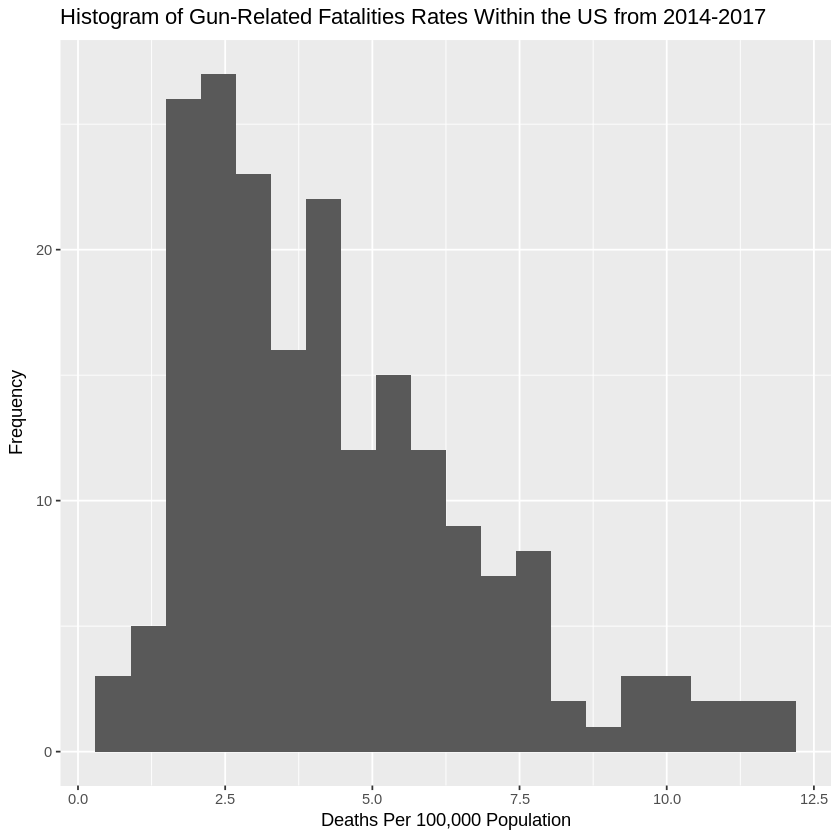

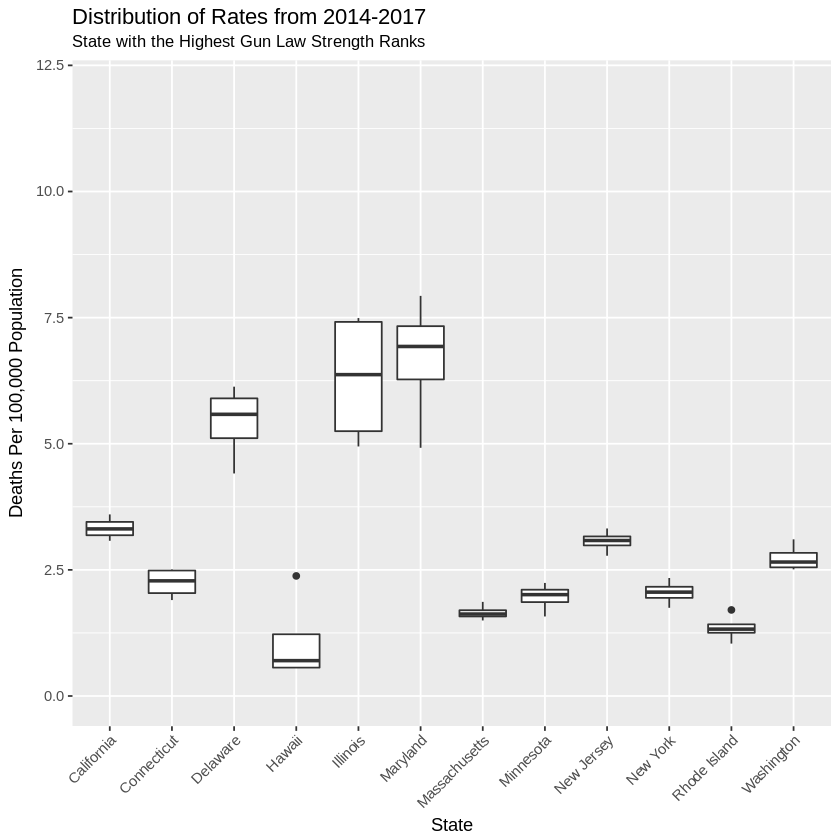

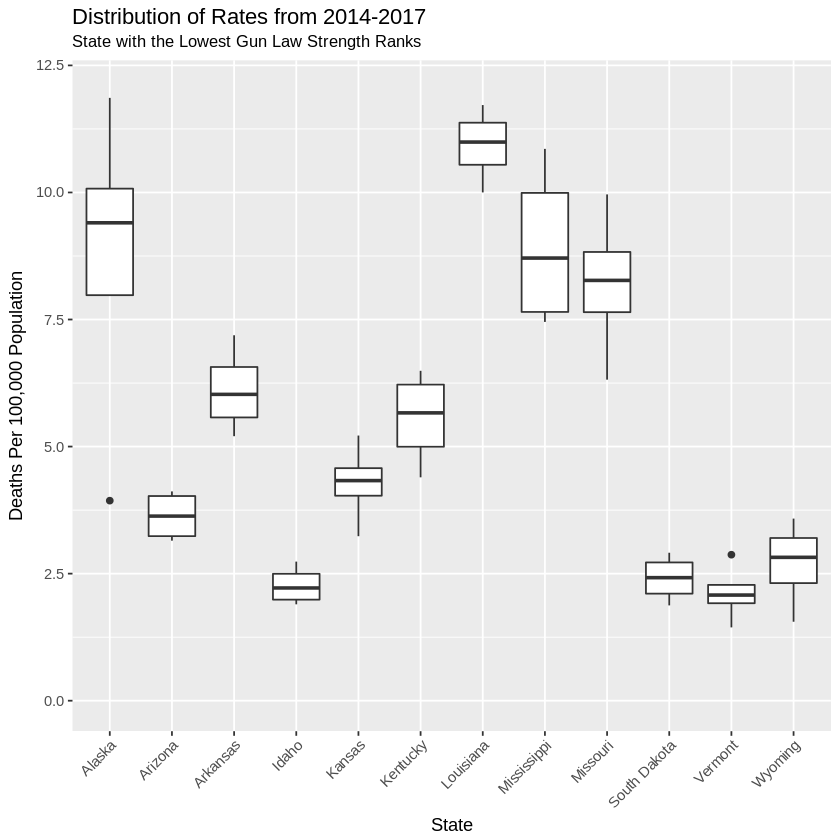

In [3]:
ggplot(state.yearbyyear.rate, aes(RatePer100000)) +
  geom_histogram(bins=20) +
  labs(
    title = 'Histogram of Gun-Related Fatalities Rates Within the US from 2014-2017',
    x = 'Deaths Per 100,000 Population',
    y = 'Frequency'
  )

ggplot(subset(state.yearbyyear.rate, GunLawCategory == 'high'), 
       aes(x=state, y=RatePer100000)) +
  geom_boxplot() + 
  labs(
    title = 'Distribution of Rates from 2014-2017',
    subtitle = 'State with the Highest Gun Law Strength Ranks',
    x = 'State',
    y = 'Deaths Per 100,000 Population'
  ) +
  scale_y_continuous(limits=c(0,12)) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1)
  )

ggplot(subset(state.yearbyyear.rate, GunLawCategory == 'low'), 
       aes(x=state, y=RatePer100000)) +
  geom_boxplot() + 
  labs(
    title = 'Distribution of Rates from 2014-2017',
    subtitle = 'State with the Lowest Gun Law Strength Ranks',
    x = 'State',
    y = 'Deaths Per 100,000 Population'
  ) +
  scale_y_continuous(limits=c(0,12)) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1)
  )  

An ANOVA was initially performed; however, after checking the residual plots of the ANOVA it was determined the data violated the assumptions of an ANOVA. At this point, non-parametric tests were used to confirm if the data was statistically different. 

The first test used was the Kruskal-Wallis rank sum test, which compared all 4 categories of gun law strength. A Dunn test was then performed to identify the significant multiple pairwise comparisons. Then a Mann-Whitney-Wilcoxon sum test was used to confirm the statistical difference between the highest and lowest categories. 

In [4]:
state.yearbyyear.rate$GunLawCategory <- as.factor(state.yearbyyear.rate$GunLawCategory)
state.kw <- kruskal.test(RatePer100000 ~ GunLawCategory, data = state.yearbyyear.rate)

state.dunn <- dunnTest(RatePer100000 ~ GunLawCategory, data = state.yearbyyear.rate, method = 'bonferroni')

state.mww.df <- subset(state.yearbyyear.rate, GunLawCategory %in% c('high', 'low'))
state.mww <- wilcox.test(RatePer100000 ~ GunLawCategory, data = state.mww.df)

The overall gun-related fatality rate for each state from 2014 to 2017 was calculated. A K-means cluster analysis was run to see if the resulting clusters would match the previously determined rankings. 

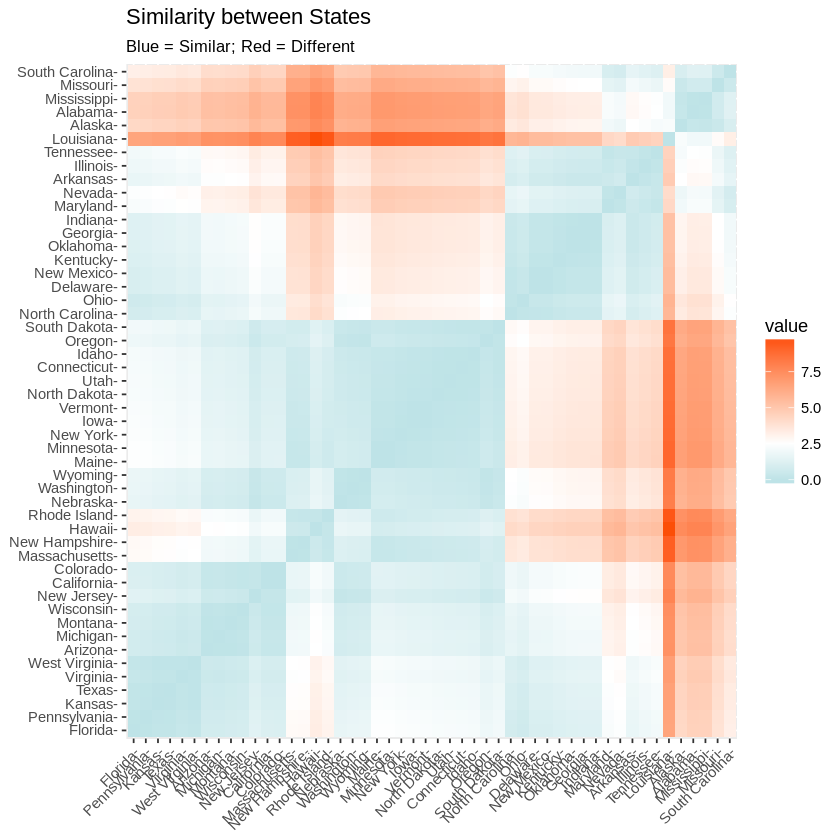

In [5]:
state.overall.rate <- state.gun.violence %>%
  left_join(state.pop, by = c('state' = 'State', 'Year' = 'Year')) %>%
  group_by(state) %>%
  summarise(TotalKilled = sum(TotalKilled),
            TotalPop = sum(Population)) %>%
  mutate(Rate = TotalKilled / TotalPop,
         RatePer100000 = Rate * 100000) %>%
  as.data.frame()

state.cluster.df <- subset(state.overall.rate, select = c(RatePer100000, state))
state.cluster.df <- subset(state.overall.rate, select = RatePer100000)
rownames(state.cluster.df) <- state.overall.rate$state
distance <- get_dist(state.cluster.df)
fviz_dist(distance, gradient = list(low = "#00AFBB", mid = "white", high = "#FC4E07")) +
  labs(
    title = 'Similarity between States',
    subtitle = 'Blue = Similar; Red = Different'
  )

state.kmean <- kmeans(state.cluster.df, centers = 4, nstart = 50)

state.cluster.df <- state.cluster.df %>%
  mutate(state = state.overall.rate$state) %>%
  mutate(cluster = as.factor(state.kmean$cluster),
         GunLawCategory = case_when(
           state %in% high.gun.law ~ 'high',
           state %in% medhigh.gun.law ~ 'medium high',
           state %in% medlow.gun.law ~ 'medium low',
           state %in% low.gun.law ~ 'low'
         ))

### Gun Legislation and Gun-Related Fatalities In and Outside the US
Data regarding gun-related fatalities from 2013 to 2016 were retrieved for the United States, United Kingdom, and Australia.<sup>7,8,9</sup> This data was aggregated by year and filtered. Deaths that occurred during legal intervention were excluded. The population data for each country by year were determined from the International Data Base compiled by the US Census Bureau.<sup>10</sup> This was used to find the gun-related fatality rate for each country by year.

In [6]:
gun.deaths <- read.csv('Data/GunRelatedDeaths.csv', header=T, stringsAsFactors = F)
national.pop <- read.csv('Data/national_populations.csv', header=T, stringsAsFactors = F)

gun.deaths.agg <- gun.deaths %>%
  filter(CauseOfDeathCode != 'Y35.0') %>%
  group_by(Year, Country) %>%
  summarise(TotalDeaths = sum(Deaths)) %>%
  as.data.frame()

gun.deaths.rate <- gun.deaths.agg %>%
  left_join(national.pop, by = c('Country', 'Year')) %>%
  mutate(Rate = TotalDeaths/Population) %>%
  mutate(RatePer100000 = Rate * 100000) %>%
  as.data.frame()

A boxplot of the data shows a large difference in the means between the US and the UK and Australia. 

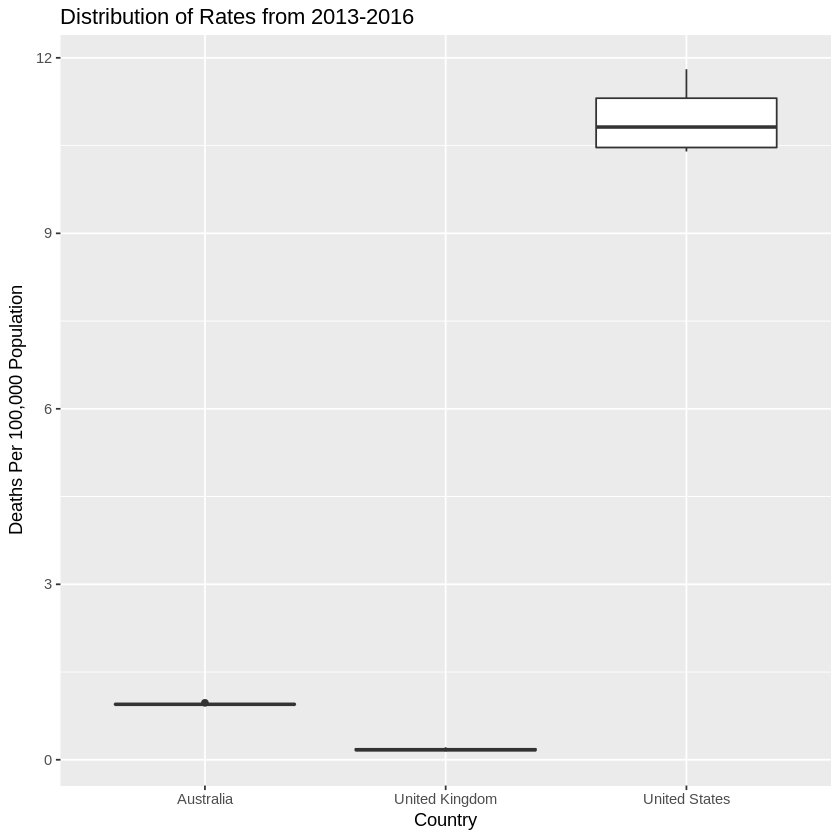

In [7]:
ggplot(gun.deaths.rate, aes(x=Country, y=RatePer100000)) +
  geom_boxplot() + 
  labs(
    title = 'Distribution of Rates from 2013-2016',
    x = 'Country',
    y = 'Deaths Per 100,000 Population'
  ) 

An ANOVA was used, but it was determined the data violated the assumptions of an ANOVA.

The Kruskal-Wallis rank sum test was performed to compared the 3 country’s gun-related fatality rates over 4 years. A Dunn test was run to find the significant multiple pairwise comparisons. Then a Mann-Whitney-Wilcoxon sum test was used to confirm the statistical difference between the US and UK.

In [8]:
gun.deaths.rate$Country <- as.factor(gun.deaths.rate$Country)
national.kw <- kruskal.test(RatePer100000 ~ Country, data = gun.deaths.rate)

national.dunn <- dunnTest(RatePer100000 ~ Country, data = gun.deaths.rate, method = 'bonferroni')

national.mww.df <- subset(gun.deaths.rate, Country %in% c('United States', 'United Kingdom'))
national.mww <- wilcox.test(RatePer100000 ~ Country, data = national.mww.df)

## Results
### Gun Legislation and Gun-Related Fatalities Within the US
The Kruskal-Wallis test determined the difference between gun law categories was significant (P < 0.01). The Dunn test further demonstrated there was a significant difference between the high gun law strength and low gun law strength categories (P adj < 0.001). It also found there were significant differences between the high and medium high categories as well as the high and medium low categories (P adj < 0.05).

In [9]:
state.kw

state.dunn


	Kruskal-Wallis rank sum test

data:  RatePer100000 by GunLawCategory
Kruskal-Wallis chi-squared = 20.258, df = 3, p-value = 0.00015


Dunn (1964) Kruskal-Wallis multiple comparison
  p-values adjusted with the Bonferroni method.



                Comparison          Z      P.unadj        P.adj
1               high - low -4.2391272 2.243905e-05 0.0001346343
2       high - medium high -3.3276582 8.757924e-04 0.0052547547
3        low - medium high  0.9954202 3.195319e-01 1.0000000000
4        high - medium low -3.1118639 1.859102e-03 0.0111546095
5         low - medium low  1.2112145 2.258132e-01 1.0000000000
6 medium high - medium low  0.2202441 8.256811e-01 1.0000000000

The Mann-Whitney-Wilcoxon test was used to further confirm the significant difference between the high gun law strength and low gun law strength states (P < 0.0001).

In [10]:
state.mww


	Wilcoxon rank sum test

data:  RatePer100000 by GunLawCategory
W = 619, p-value = 6.765e-05
alternative hypothesis: true location shift is not equal to 0


The K-means clusters did not match the gun law strength categories.

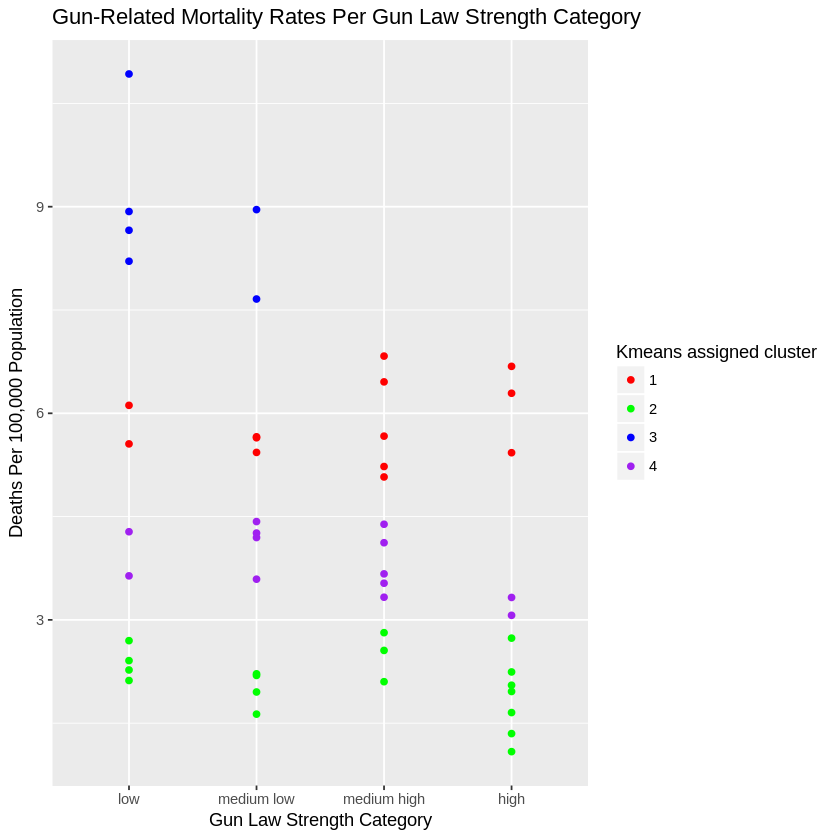

In [11]:
#state.kmean

state.cluster.df$GunLawCategory <- factor(state.cluster.df$GunLawCategory, levels = c('low', 'medium low', 'medium high', 'high'))
ggplot(state.cluster.df, aes(x=GunLawCategory, y=RatePer100000, color=cluster, group=cluster)) +
  geom_point() +
  labs(
    title = 'Gun-Related Mortality Rates Per Gun Law Strength Category',
    x = 'Gun Law Strength Category',
    y = 'Deaths Per 100,000 Population'
  ) + 
  scale_color_manual(name='Kmeans assigned cluster', values = c('red', 'green', 'blue', 'purple'))

### Gun Legislation and Gun-Related Fatalities In and Outside the US
The Kruskal-Wallis test demonstrated there is a significant difference between the 3 countries (P < 0.01). The Dunn test identified a significant difference between the US and UK (P adj < 0.01).

In [12]:
national.kw

national.dunn


	Kruskal-Wallis rank sum test

data:  RatePer100000 by Country
Kruskal-Wallis chi-squared = 9.8462, df = 2, p-value = 0.007277


Dunn (1964) Kruskal-Wallis multiple comparison
  p-values adjusted with the Bonferroni method.



                      Comparison         Z     P.unadj       P.adj
1     Australia - United Kingdom  1.568929 0.116664465 0.349993394
2      Australia - United States -1.568929 0.116664465 0.349993394
3 United Kingdom - United States -3.137858 0.001701872 0.005105616

The Mann-Whitney-Wilcoxon test confirmed the significant difference identified between the US and UK (P < 0.05). 

In [13]:
national.mww


	Wilcoxon rank sum test

data:  RatePer100000 by Country
W = 0, p-value = 0.02857
alternative hypothesis: true location shift is not equal to 0


## Future Steps
This analysis has shown there is a definite correlation between strength of gun laws and gun-related fatality rates; however, further analysis is needed to take into account the multiple covariates, besides strength of gun laws, that affect gun-related fatality rates, such as socioeconomic status. 

It would be good to review if fatality rates related to other violence are higher in these states with lower gun-related fatality rates. 

Gun legislation put in place by the Obama administration has been repealed in the Trump administration. It would be interesting to see if this has an effect on the national gun-related fatality rate. 

## References
1.	Gerstein NS, Sanders JC, McCunn M, Brierley JK, Gerstein WH, West SD, et al. The Gun Violence Epidemic: Time for Perioperative Physicians to Act. J Cardiothorac Vasc Anesth. 2018.
2.	Fleegler EW, Lee LK, Monuteaux MC, Hemenway D, Mannix R. Firearm legislation and firearm-related fatalities in the United States. JAMA Intern Med. 2013;173(9):732-40.
3.	Lee LK, Fleegler EW, Farrell C, Avakame E, Srinivasan S, Hemenway D, et al. Firearm Laws and Firearm Homicides: A Systematic Review. JAMA Intern Med. 2017;177(1):106-19.
4.	Ko J. Gun Violence Data [Internet]. 2018 [updated 2018 Apr 14; cited 2018 Apr 23]. Available from: https://github.com/jamesqo/gun-violence-data
5.	United States Census Bureau. State Population Estimates [Internet]. Washington, DC: United States Census Bureau; 2018 [updated 2018 Mar 22; cited 2018 Apr 23]. Available from: https://www2.census.gov/programs-surveys/popest/datasets/
6.	Giffords Law Center to Prevent Gun Violence. Annual Gun Law Scorecard [Internet]. San Francisco: Giffords Law Center to Prevent Gun Violence; 2018 [updated 2018; cited 2018 Apr 23]. Available from: http://lawcenter.giffords.org/scorecard/#rankings
7.	Centers for Disease Control and Prevention. Underlying Cause of Death [Internet]. Atlanta: Centers for Disease Control and Prevention; 2017 [updated 2018 Feb 9; cited 2018 Apr 23]. Available from: https://wonder.cdc.gov/
8.	Australian Bureau of Statistics. Underlying Causes of Death [Internet]. Canberra: Australian Bureau of Statistics; 2017[updated 2017 Sep 27; cited 2018 Apr 23]. Available from: http://www.abs.gov.au/AUSSTATS/abs@.nsf/DetailsPage/3303.02016?OpenDocument
9.	Office for National Statistics. Mortality statistics - underlying cause, age, and sex [Internet]. Durham: Durham University; 2017 [updated 2017 Dec 10; cited 2018 Apr 23]. Available from: https://www.nomisweb.co.uk/query/construct/summary.asp?mode=construct&version=0&dataset=161
10.	United States Census Bureau. International Data Base [Internet]. Washington, DC: United States Census Bureau; 2017 [updated 2017 Dec 5; cited 2018 Apr 23]. Available from: https://www.census.gov/programs-surveys/international-programs/about/idb.html